<a href="https://colab.research.google.com/github/MikhailMikheev17/123/blob/master/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи
У нас есть чистый набор данных, сгенерированный на основе идентификатора IDS, который также помечен как "0" в случае отсутствия атаки и "1" в случае атаки.
В этом наборе данных мы пройдем различные процедуры предварительной обработки, которые хорошо известны, чтобы сделать этот блокнот более понятным.
Данные чистые, но нам нужно убедиться, что каждая функция важна для модели, используя "Важность функции", которая отображается в сгенерированной модели.




In [1]:
import math, time, random, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import missingno
import pickle

<ipython-input-1-786145a7770e>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


#### Ознакомьтесь с учебным и тестовым набором.

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train = pd.read_csv('/content/UNSW_NB15_training-set.csv')
test = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
test.head()



,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


Мы можем сделать то, что описано ниже, но мы хотели бы объединить как обучающий, так и тестовый наборы, чтобы избежать повторной предварительной обработки.

In [ ]:
#X_train = train.drop(['label'], axis=1)
#Y_train = train['label']
#X_test = test.drop(['label'], axis=1)
#Y_test = test['label']
#

In [4]:
data = pd.concat([train,test]).reset_index(drop=True)
cols_cat = data.select_dtypes('object').columns # To be explained later
cols_numeric = data._get_numeric_data().columns # To be explained later

In [5]:
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [6]:
data.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,72811.823858,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,...,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,0.639077
std,48929.917641,5.974305,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,...,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,0.480269
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,32210.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,64419.000000,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,110923.000000,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,...,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,1.000000
max,175341.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,...,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


# Пропущенные значения:

 <ul>
 <li>
 Проверьте, нет ли пропущенных значений.
 </li>
 <li>
 Замените эти пропущенные значения.
 </li>
 </ul>

In [7]:
print(data.isnull().sum())

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

<Axes: >

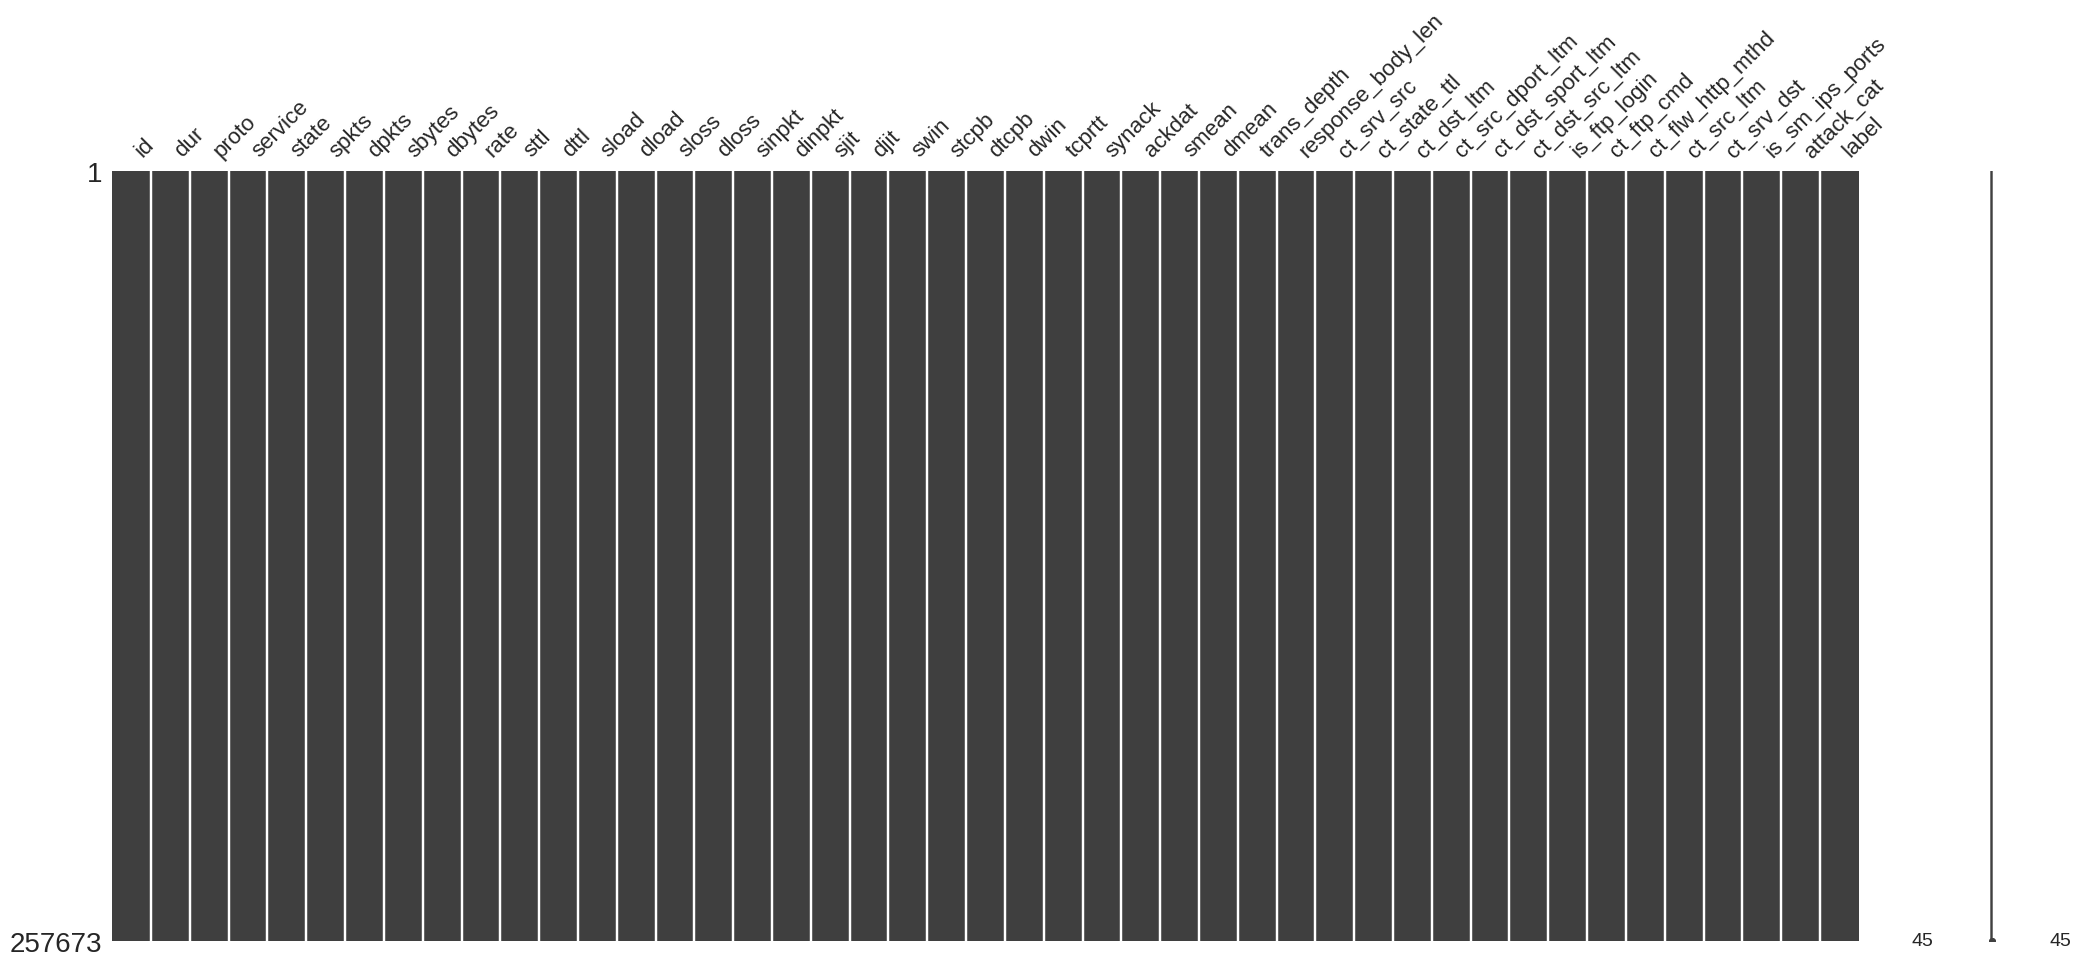

In [8]:
missingno.matrix(data)

Данные чисты, и в них нет пропущенных значений.

# Идеи и шаги:
 <ul>
 <li>
 Данные чисты.
 </li>
 <li>
 Данные все еще нуждаются в дальнейшей обработке с точки зрения однократного кодирования категориальных данных.
 Например: "сервис" состоит из разных типов, у нас есть ftp, http и обозначение "-" (недоступно или отсутствует), поэтому нам нужно будет рассматривать его как отсутствующее значение, поскольку мы изменим его с "-" на "Нет" вместо того, чтобы удалять весь столбец.
 </li>
 <li>
 Удаление ненужных функций, таких как "идентификатор".
 </li>
 </ul>

In [9]:
data['proto'].unique() #This is definitely a categorical feature.

array(['udp', 'arp', 'tcp', 'igmp', 'ospf', 'sctp', 'gre', 'ggp', 'ip',
       'ipnip', 'st2', 'argus', 'chaos', 'egp', 'emcon', 'nvp', 'pup',
       'xnet', 'mux', 'dcn', 'hmp', 'prm', 'trunk-1', 'trunk-2',
       'xns-idp', 'leaf-1', 'leaf-2', 'irtp', 'rdp', 'netblt', 'mfe-nsp',
       'merit-inp', '3pc', 'idpr', 'ddp', 'idpr-cmtp', 'tp++', 'ipv6',
       'sdrp', 'ipv6-frag', 'ipv6-route', 'idrp', 'mhrp', 'i-nlsp', 'rvd',
       'mobile', 'narp', 'skip', 'tlsp', 'ipv6-no', 'any', 'ipv6-opts',
       'cftp', 'sat-expak', 'ippc', 'kryptolan', 'sat-mon', 'cpnx', 'wsn',
       'pvp', 'br-sat-mon', 'sun-nd', 'wb-mon', 'vmtp', 'ttp', 'vines',
       'nsfnet-igp', 'dgp', 'eigrp', 'tcf', 'sprite-rpc', 'larp', 'mtp',
       'ax.25', 'ipip', 'aes-sp3-d', 'micp', 'encap', 'pri-enc', 'gmtp',
       'ifmp', 'pnni', 'qnx', 'scps', 'cbt', 'bbn-rcc', 'igp', 'bna',
       'swipe', 'visa', 'ipcv', 'cphb', 'iso-tp4', 'wb-expak', 'sep',
       'secure-vmtp', 'xtp', 'il', 'rsvp', 'unas', 'fc', 'iso-ip',


In [10]:
data['service'].unique() #Here, we'll deal with the type of service that is '-'
data['service']= np.where(data['service'] == '-', 'None', data['service'])
print(data['service'].unique())

['None' 'http' 'ftp' 'ftp-data' 'smtp' 'pop3' 'dns' 'snmp' 'ssl' 'dhcp'
 'irc' 'radius' 'ssh']


In [11]:
data['state'].unique() #Keep it.

array(['INT', 'FIN', 'REQ', 'ACC', 'CON', 'RST', 'CLO', 'ECO', 'PAR',
       'URN', 'no'], dtype=object)

##### Теперь давайте попробуем автоматизировать этот процесс.

In [12]:
def Remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', 'None', data[col])
    return data

In [13]:
cols = data.columns
data_bin = Remove_dump_values(data, cols)

**Удаление ненужных функций:**

In [14]:
data_bin = data_bin.drop(['id'], axis=1) #Remove Unnecessary features

##### Категориальные признаки:
Одна горячая кодировка с использованием cols_cat

In [15]:
data_bin.drop(['attack_cat'], axis=1, inplace=True)

In [16]:
cols_cat = cols_cat.drop(['attack_cat'])

**Выполните однократное горячее кодирование**

In [17]:
data_bin_hot = pd.get_dummies(data_bin,columns=cols_cat)

In [18]:
data_bin_hot.shape

(257673, 197)

##### Нормализация:
Нормализуйте все значения в наборе данных.

In [19]:
cols_numeric = list(cols_numeric)
cols_numeric.remove('label')
cols_numeric.remove('id')

In [20]:
data_bin_hot[cols_numeric] = data_bin_hot[cols_numeric].astype('float')

In [21]:
data_bin_hot[cols_numeric] = (data_bin_hot[cols_numeric] - np.min(data_bin_hot[cols_numeric])) / np.std(data_bin_hot[cols_numeric])

In [ ]:
data_bin_hot.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.000011,2.0,0.0,496.0,0.0,90909.0902,254.0,0.0,180363632.0,0.0,...,False,False,False,False,True,False,False,False,False,False
1,0.000008,2.0,0.0,1762.0,0.0,125000.0003,254.0,0.0,881000000.0,0.0,...,False,False,False,False,True,False,False,False,False,False
2,0.000005,2.0,0.0,1068.0,0.0,200000.0051,254.0,0.0,854400000.0,0.0,...,False,False,False,False,True,False,False,False,False,False
3,0.000006,2.0,0.0,900.0,0.0,166666.6608,254.0,0.0,600000000.0,0.0,...,False,False,False,False,True,False,False,False,False,False
4,0.000010,2.0,0.0,2126.0,0.0,100000.0025,254.0,0.0,850400000.0,0.0,...,False,False,False,False,True,False,False,False,False,False


# Разделение обучающего и тестового наборов:


Мы не будем разделять данные.. В нашем случае мы заботимся о точности!

In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)

In [22]:
from sklearn import model_selection
from sklearn import metrics
X = data_bin_hot.drop('label', axis=1)
Y = data_bin_hot['label']
global X

# Модель машинного обучения:
<ul>
 <li>
 Это задача классификации, в которой мы хотим определить, есть атака или нет.
 </li>
 <li>
 Деревья решений
 </li>

 </ul>

In [23]:
def fit_algo(algo, x, y, cv):
    #Fit the model
    model = algo.fit(x, y)

    #Check its score
    acc = round(model.score(x, y) *100, 2)
    y_pred = model_selection.cross_val_predict(algo, x, y, cv=cv, n_jobs = -1)

    acc_cv = round(metrics.accuracy_score(Y,y_pred)*100, 2)

    return y_pred, acc, acc_cv, model

# Дерево принятия решений

In [24]:
from sklearn.tree import DecisionTreeClassifier
start_time = time.time()
pred_now, acc_dt, acc_cv_dt, dt = fit_algo(DecisionTreeClassifier(random_state = 1)
                                        , X, Y, 10)

dt_time = (time.time() - start_time)

print("Accuracy: %s" % acc_dt)
print("Accuracy of CV: %s" % acc_cv_dt)
print("Execution time: %s" % dt_time)

Accuracy: 99.74
Accuracy of CV: 91.43
Execution time: 72.1261842250824


# Сохранение модели


In [ ]:
filename = 'Decision Tree_IDS.sav'
pickle.dump(dt, open(filename, 'wb'))